# Import

In [1]:
import json
import os
import pandas as pd
from basic.slave.slave import *
from tqdm import tqdm

# Parameters

In [2]:
config_info = {
    "index": {
        "irank": {
            "mean_long": 14,
            "mean_short": 9,
            "c_base_long": 5,
            "v_base_long": 5,
            "ad_base_long": 5,
            "obv_base_long": 5
            # "unused_symbols": ['BTCUSDT', 'ETHUSDT', 'SOLUSDT', 'XRPUSDT', 'DOGEUSDT']
        }
    },
    "main": {
        "loss_p": -0.03,
        "profit_p": 0.05,
        "_alarm": {
            "clear": ['12:00'],
            "orders": ['23:00']
        },
        "_timer": {
            "orders": 60,
            "positions": 1
        },
    },
    "trade": {
        "amountusd": 10000,
        "apikey": "xxxxx",
        "apisets": {
            "bbo": "QUEUE",
            "count_cancel": 5,
            "iceberg": 10000,
            "offer_step": 1,
            "retry": 1,
            "timeInForce": "GTC"
        },
        "hold_time": 240,
        "leverage": 2,
        "orders_type": "BBO",
        "position_type": "BBO",
        "stop_iceberg": 10000,
        "stop_interval": 0.1,
    }
}

# Read

In [3]:
def get_raw_data(path):
    base_url = path['filepath']
    path1 = f"/{path['symbol']}/{path['interval']}"
    url = base_url + path1
    filelist = os.listdir(url)
    filelist.sort()
    filelist_get = [item for item in filelist if
                    path['start_date'] <= item[len(path['symbol']) + 4:len(path['symbol']) + 14] <= path[
                        'end_date']]
    df = pd.DataFrame()
    for file in tqdm(filelist_get):
        df0 = pd.read_csv(fr'{url}/{file}')
        df = pd.concat([df, df0])
    return df.copy()

In [4]:
path_params = {
    'filepath': 'Z:\\um\daily\klines',
    'symbol': 'ETHUSDT',
    'start_date': '2025-02-01',
    'end_date': '2025-08-23',
    'interval': '1m',
}
df = get_raw_data(path_params)
df_klines = df[['open_time', 'open', 'high', 'low', 'close', 'volume']].copy()
df_klines.columns = ['t', 'o', 'h', 'l', 'c', 'v']
df_klines['t'] = df_klines['t'] + 60000
df_klines.set_index('t', inplace=True)

100%|██████████| 204/204 [00:07<00:00, 28.17it/s]


# index

In [5]:
class IRANK():

    def __init__(self, paras, algoid):
        self.paras = paras
        self.algoid = algoid
        self.ad_now = 0
        self.df_klines = None
        # self.pre_time = 0
        self.calculate()

    def update(self, idx):
        target_prod = []
        if self.df_klines[f'c_ma{self.paras["mean_long"]}'].loc[idx] < self.df_klines['c'].loc[idx] < self.df_klines[
                                                                                                          'c'].loc[
                                                                                                      idx - self.paras[
                                                                                                          'c_base_long'] * 60000:idx].min() and \
                self.df_klines[f'c_ma{self.paras["mean_short"]}'].loc[idx] > \
                self.df_klines[f'c_ma{self.paras["mean_long"]}'].loc[idx] and \
                self.df_klines['ad'].loc[idx] > self.df_klines['ad'].loc[
                                                idx - self.paras['ad_base_long'] * 60000:idx].min() and \
                self.df_klines['v'].loc[idx] > self.df_klines['v'].loc[
                                               idx - self.paras['v_base_long'] * 60000:idx].mean():
            target_prod.append({'symbol': 'c', 'side': 'SELL'})

        elif self.df_klines[f'c_ma{self.paras["mean_long"]}'].loc[idx] > self.df_klines['c'].loc[idx] > self.df_klines[
                                                                                                            'c'].loc[
                                                                                                        idx -
                                                                                                        self.paras[
                                                                                                            'c_base_long'] * 60000:idx].min() and \
                self.df_klines[f'c_ma{self.paras["mean_short"]}'].loc[idx] < \
                self.df_klines[f'c_ma{self.paras["mean_long"]}'].loc[idx] and \
                self.df_klines['ad'].loc[idx] < self.df_klines['ad'].loc[
                                                idx - self.paras['ad_base_long'] * 60000:idx].max() and \
                self.df_klines['v'].loc[idx] > self.df_klines['v'].loc[
                                               idx - self.paras['v_base_long'] * 60000:idx].mean():
            target_prod.append({'symbol': 'c', 'side': 'BUY'})
        return target_prod

    def calculate(self):
        global df_klines
        df_klines['MoneyFlowVolume'] = (2 * df_klines['c'] - df_klines['l'] - df_klines['h']) / (
                df_klines['h'] - df_klines['l']) * df_klines['v']
        df_klines['ad'] = df_klines['MoneyFlowVolume'].cumsum()  # 计算累计派发线
        df_klines['obv'] = ((df_klines['c'] - df_klines['o']) * df_klines['v']).cumsum()  # 计算成交量的累计叠加
        df_klines[f'c_ma{self.paras["mean_long"]}'] = df_klines['c'].rolling(self.paras['mean_long']).mean()  # 长周期
        df_klines[f'c_ma{self.paras["mean_short"]}'] = df_klines['c'].rolling(self.paras['mean_short']).mean()  # 短周期
        df_klines = df_klines.dropna()
        self.df_klines = df_klines


In [6]:
irank = IRANK(config_info['index']['irank'], algoid='rank0')

In [7]:
irank.df_klines

,o,h,l,c,v,MoneyFlowVolume,ad,obv,c_ma14,c_ma9
t,,,,,,,,,,
1738368840000,3298.24,3303.68,3298.00,3303.06,951.854,744.054887,2.343130e+03,2.282662e+04,3296.651429,3299.180000
1738368900000,3303.06,3305.02,3302.44,3303.62,1657.820,-141.364496,2.201766e+03,2.375500e+04,3297.197143,3300.491111
1738368960000,3303.61,3312.16,3303.61,3309.87,15031.895,6979.722006,9.181488e+03,1.178547e+05,3298.331429,3301.724444
1738369020000,3309.91,3310.63,3305.36,3305.37,1348.832,-1343.713093,7.837775e+03,1.117310e+05,3299.382857,3302.504444
1738369080000,3305.36,3307.69,3300.09,3302.37,1609.067,-643.626800,7.194148e+03,1.069199e+05,3300.431429,3302.951111
...,...,...,...,...,...,...,...,...,...,...
1755993360000,4774.12,4775.80,4774.12,4775.37,980.004,478.335286,1.209247e+07,-1.670917e+08,4772.917857,4772.367778
1755993420000,4775.36,4777.00,4775.36,4775.41,820.597,-770.560598,1.209170e+07,-1.670916e+08,4773.190714,4772.773333
1755993480000,4775.41,4775.41,4775.00,4775.00,450.097,-450.097000,1.209125e+07,-1.670918e+08,4773.245000,4773.391111


# Algo

In [8]:
class MAIN(SLAVE):

    def __init__(self):
        algoid, config, client, index = None, config_info, None, None
        self.config = config['main']
        self.irank = irank
        super().__init__(client=client, paras=config['trade'], algoid=algoid)

    def x_orders(self):
        # global lock
        target_prod = self.irank.update(HELPER.last_ticker_time())
        if len(target_prod) == 0 or self.infos['total_positions'] != 0:
            return
        # lock = True
        self.slave_orders(target_prod)

    def x_positions(self):
        # global lock

        if self.infos['total_abs_positions'] == 0:
            return 1
        action_info = {}
        for groupid in self.infos['groups']:
            the_trade = self.infos['trades'][(groupid, list(self.infos['groups'][groupid])[0])]
            if self.infos['profits'][groupid] < self.config['loss_p'] * self.infos['abs_originals'][groupid]:
                action_info[groupid] = 'stop'
            elif self.infos['profits'][groupid] > self.config['profit_p'] * self.infos['abs_originals'][groupid]:
                action_info[groupid] = 'take_profit'

            # elif self.infos['positions'][groupid] > 0 and df3['qv'].loc[HELPER.last_ticker_time()] < self.config[
            #     'qv_thre']:
            #     action_info[groupid] = 'take_profit'
            # #     # with open("trades", "a") as f:
            # #     #     f.write("buy_take_profit" + '\n')
            # #     #     f.write(f"now_idx:{HELPER.last_ticker_time()}")
            # #     #     f.write("\n")
            # #     #     f.write(f"{self.infos['trades']}")
            # #     #     f.write("\n")
            # #
            # elif self.infos['positions'][groupid] < 0 and df3['qv'].loc[HELPER.last_ticker_time()] < self.config[
            #     'qv_thre']:
            #     action_info[groupid] = 'take_profit'
            # #     # with open("trades", "a") as f:
            # #     #     f.write("sell_take_profit" + '\n')
            # #     #     f.write(f"now_idx:{HELPER.last_ticker_time()}")
            # #     #     f.write("\n")
            # #     #     f.write(f"{self.infos['trades']}")
            # #     #     f.write("\n")

        if not action_info:
            return 0
        # lock = False
        self.slave_positions(action_info)
        return 0

    def x_clear(self):
        self.base_clear()

In [9]:
main = MAIN()

In [10]:

def job(day):
    result = []

    for idx in tqdm(day):
        HELPER.update(idx, df_klines)
        main.base_infos()
        if main.x_positions():

            result_cur = HELPER.profit(infos=main.infos, method='group')

            if result_cur is not None:
                result += result_cur
                main.x_clear()

        main.base_infos()
        main.x_orders()

    main.base_infos()
    return result

In [11]:
result = HELPER.driver(df=df_klines, job=job, n_jobs=1, clear=config_info['main']['_alarm']['clear'][0],
                       start='2025-01-01', end='2025-08-24')

100%|██████████| 293747/293747 [01:40<00:00, 2924.35it/s]


In [12]:
result_df = pd.DataFrame(result)
result_df

,0,1
0,1738374420000,-299.0
1,1738407120000,-299.0
2,1738449000000,-310.0
3,1738514760000,-316.0
4,1738522440000,-422.0
...,...,...
197,1755632340000,501.0
198,1755724020000,-300.0
199,1755795780000,519.0
200,1755874740000,503.0


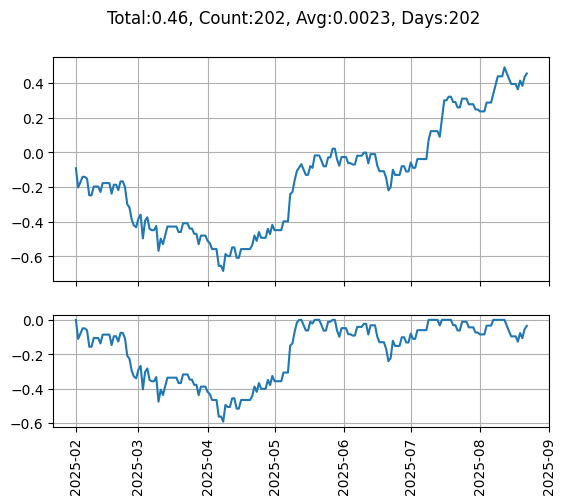

In [13]:
fig, axes, arr = PLOT.profit(result=result, amountusd=config_info['trade']['amountusd'], freq='D')